### Analysis V2


In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely.wkt
import utilities
from calitp import *
from shared_utils import geography_utils, utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

### Simplified Provider Maps

In [3]:
# Simple Version
verizon_simple, att_simple, tmobile_simple = utilities.simplify_geometry_all_providers()

In [4]:
# Geometries are true across each gdf
verizon_simple.geometry.is_valid.all(), att_simple.geometry.is_valid.all(), tmobile_simple.geometry.is_valid.all(),

(True, True, True)

In [5]:
# att_og = utilities.load_att()
# tmobile_og = utilities.load_tmobile()

In [6]:
# Geometries are true across each gdf
# verizon_og.geometry.is_valid.all(), att_og.geometry.is_valid.all(), tmobile_og.geometry.is_valid.all(),

In [7]:
unique_routes = utilities.load_unique_routes_df()

In [8]:
len(unique_routes)

2829

In [9]:
# Ensure CRS are the same
unique_routes.crs == att_simple.crs == tmobile_simple.crs == verizon_simple.crs

True

In [10]:
verizon, att, tmobile = utilities.simplify_geometry_all_providers()

<AxesSubplot:>

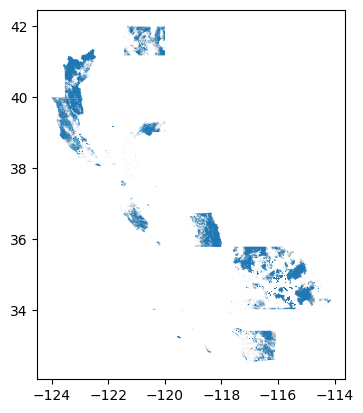

In [15]:
verizon.plot()

<AxesSubplot:>

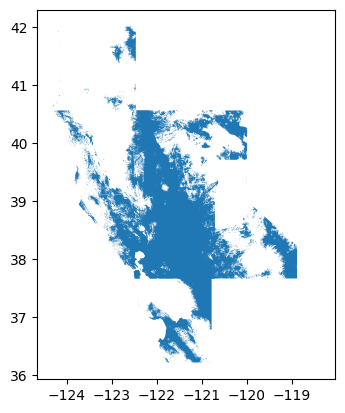

In [12]:
att.plot()

In [68]:
att_original_provider = gpd.read_parquet(
    f"{utilities.GCS_FILE_PATH}att_ca_only.parquet")

<AxesSubplot:>

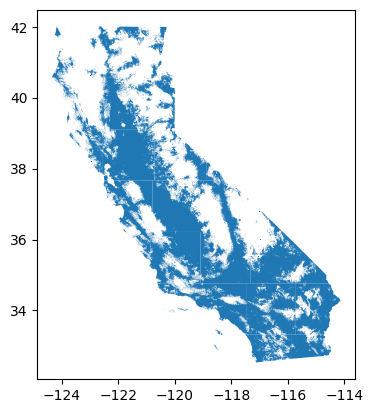

In [69]:
att_original_provider.plot()

<AxesSubplot:>

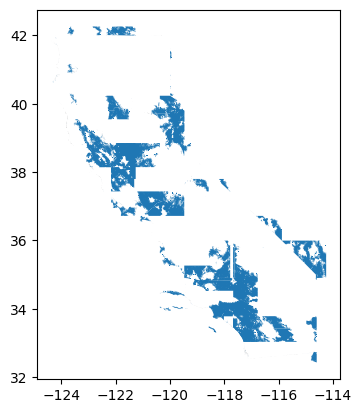

In [13]:
tmobile.plot()

### Notes
* Verizon_simple works with `comparison` however around 500 routes are passed when using `overlay_single_routes`.
* Verizon_og does not work. Returns the error: `TopologyException: side location conflict at -122.30299999995003 37.938999999750251. This can occur if the input geometry is invalid.`
* Both gdf returns `true` when `.geometry.is_valid.all()` is applied to them.
* Used the simplified version of tmobile and AT&T (created using `simplify_geometry_all_providers()`) with `comparison` function.

In [16]:
def overlay_single_routes(
    provider: gpd.GeoDataFrame, routes: gpd.GeoDataFrame, provider_name: str
):
    """
    For any provider or routes that may cause an issue,
    use this function to pass and print out the names of
    problematic routes.
    """

    # Empty dataframe to hold results
    all_intersected_routes = pd.DataFrame()

    # List of long route names
    unique_routes_list = routes.long_route_name.unique().tolist()

    # Intersect route by route, skipping those that don't work
    for i in unique_routes_list:
        filtered = routes[routes.long_route_name == i].reset_index(drop=True)
        try:
            intersected = gpd.overlay(
                provider, filtered, how="intersection", keep_geom_type=False
            )
            all_intersected_routes = pd.concat(
                [all_intersected_routes, intersected], axis=0
            )
        except:
            pass
            print(f"{i}")

    utils.geoparquet_gcs_export(
        all_intersected_routes,
        utilities.GCS_FILE_PATH,
        f"{provider_name}_overlaid_with_unique_routes",
    )

    return all_intersected_routes

### Function Ideas
* Other Function should:
    * Drop Duplicates
    * Sum up new route length by long route name
    * Find max of original route length
    * Divide new route length by original to get percentage covered. 
    * Del irrelevant columns
    * Does it have to be a gdf at this point or can it just be a normal dataframe?
* Now if something has a low percentage of intersecting: that is a good sign? 
* Maps only contain areas *without* coverage. So if it only intersects a little, means route mostly has coverage?

In [17]:
# verizon_o = utilities.comparison(verizon_og, unique_routes, "verizon")

In [18]:
# TopologyException: side location conflict at -122.30299999995003 37.938999999750251. This can occur if the input geometry is invalid.
# verizon_o = utilities.comparison(verizon_og, unique_routes, "verizon_simplified")

In [19]:
att_overlay = gpd.read_parquet(
    f"{utilities.GCS_FILE_PATH}att_overlaid_with_unique_routes.parquet"
)

In [21]:
len(att_overlay)

1988

In [22]:
tmobile_overlay = gpd.read_parquet(
    f"{utilities.GCS_FILE_PATH}tmobile_simplified_overlaid_with_unique_routes.parquet"
)

In [47]:
def drop_duplicates_dissolve(provider: gpd.GeoDataFrame):
    """
    Drop duplicate rows of the provider map overlaid
    with unique routes. Aggregate so there's only
    one row for each route-agency-route ID combo. 
    Find % of new route length compared with original 
    route length.
    """
    provider = provider.drop_duplicates()
    
    provider = provider.dissolve(
         by=["agency","long_route_name"],
         aggfunc={
         "route_length": "sum", "original_route_length":"max"}).reset_index()
    
    provider["percentage_route_covered"] = ((provider["route_length"] / provider["original_route_length"])* 100).astype('int64')
    
    return provider

In [48]:
att_agg = drop_duplicates_dissolve(att_overlay)

In [50]:
tmobile_agg = drop_duplicates_dissolve(tmobile_overlay)

In [51]:
len(att_agg), att_agg.long_route_name.nunique()

(1071, 1071)

In [52]:
len(tmobile_agg), tmobile_agg.long_route_name.nunique()

(1678, 1678)

In [54]:
# tmobile_agg.percentage_route_covered.value_counts()

In [64]:
tmobile_agg_filtered = (tmobile_agg[tmobile_agg.percentage_route_covered == 100 ]).reset_index(drop = True)

In [67]:
# tmobile_agg_filtered.drop(columns=['geometry']).sample(50)

In [45]:
# tmobile_agg_filtered.long_route_name.unique().tolist()

In [ ]:
"""def split_routes():
    unique_routes = utilities.load_unique_routes_df()
    # Split unique_routes to 4 different ones
    # https://stackoverflow.com/questions/17315737/split-a-large-pandas-dataframe
    df_split = np.array_split(unique_routes, 4)
    
    df1 = df_split[0]
    df2 = df_split[1]
    df3 = df_split[2]
    df4 = df_split[3]
    
    return df1,df2,df3,df4
"""